# Projet de Machine Learning Master 2 IEF 2023/2024

***

## I - Présentation du sujet

### Régression : modélisation du diffusiomètre NSCAT

### Introduction 
A l’aide des Perceptrons Multicouches (PMC), on veut simuler la fonction directe d’un diffusiomètre satellitaire.  

Le diffusiomètre est un radar actif d’observation de la surface océanique (actif car il possède sa propre source d’illumination de la surface d’observation, par rapport à d’autres radars dits passifs qui utilisent le rayonnement solaire). Son principe de mesure est basé sur la réflexion diffuse des ondes électromagnétiques qu’il a émises et qui sont diffusées dans toutes les directions par la surface océanique.  
Le coefficient de rétrodiffusion qu’il mesure est le rapport entre la puissance diffusée dans la direction du radar donc rétrodiffusée et la puissance incidente émise. Ce coefficient de rétrodiffusion (noté ***sigma0*** ou ***s0***) dépend de la rugosité de la surface de l’océan, de la géométrie de mesure (angle de visée ou d’incidence ***q***) et des caractéristiques du radar (la fréquence du signal utilisé, la polarisation des ondes électromagnétiques). 
La rugosité de surface dépend au premier ordre d’approximation du vent local soufflant sur la surface. Le vent engendre,
par l’intermédiaire d’une force de frottement, des vaguelettes de quelques centimètres de ***LO***   (longueur d’onde ou la distance entre 2 crêtes) qui elles interagissent avec les ondes émises par le radar, ondes aussi de quelques centimètres de ***LO***, selon les caractéristiques radars utilisées

Le diffusiomètre effectue des mesures à incidence oblique (***q*** entre 20°C et 50°C), plus le vent est fort, plus la diffusion est importante et donc plus la mesure radar est forte. En résumé : à vent fort, diffusion plus importante dans toutes les directions et signal mesuré fort, tandis qu’à vent faible, faible diffusion dans la direction du radar et donc signal mesuré plus faible. 
Dans le cadre de ce projet, le diffusiomètre utilisé est le NSCAT dévelopé par la NASA. Il travaille en bande Ku (14 GHz) et effectue des mesures en polarisations verticale (VV) et horizontale (HH) de ***s0*** .

***


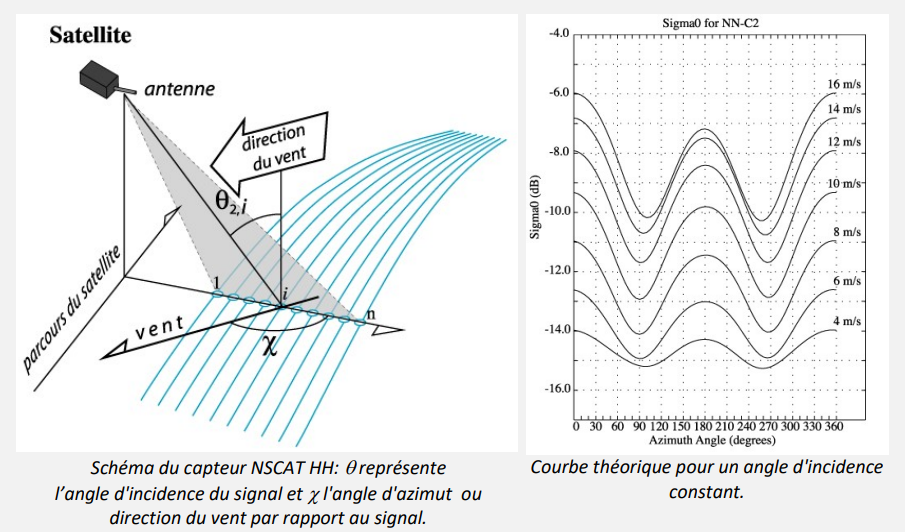

***
## II - Présentation et chargement des données

Les données sont constituées d’une base de données issue du radar NSCAT du satellite SeaScat. 
Leur taille et d’un peu plus de 4000 exemples. 4 fichiers sont inclus :
 * Diffu_Dir.dat : Angle d'azimut (en degré) ou direction du vent (***c***)
 * Diffu_Inc.dat : Angle d'incidence (en degré) du signal (***q***)
 * Diffu_Vit.dat : Module de la vitesse du vent : ***n*** (en m/s).
 * Diffu_Sig.dat : ***Sigma0*** (ou s0), composante HH uniquement (en ***dB***)
 
Cette base n'est pas égalisée (voir histogrammes de fréquences ci-dessous), il y a bien plus d'exemples pour les basses vitesses que pour les hautes. Certains angles d'azimut sont mieux représentés que d'autres.

In [15]:
%matplotlib inline

In [61]:
from warnings import warn

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [17]:
# Chargement des donnees brutes
direction = np.loadtxt("Diffu_Dir.dat")[:,None]
vitesse   = np.loadtxt("Diffu_Vit.dat")[:,None]
incidence = np.loadtxt("Diffu_Inc.dat")[:,None]
sigma0    = np.loadtxt("Diffu_Sig.dat")[:,None]

In [18]:
# Quelques transformations préliminaires 
direction_sin = np.sin(direction/180*np.pi)
direction_cos = np.cos(direction/180*np.pi)
vitesse_log = np.log(vitesse)

In [19]:
# On regroupe dans X les variables explicatives et la variable d'intérêt Sigma0
X = np.hstack((direction, direction_sin, direction_cos, vitesse, vitesse_log, incidence, sigma0))
variables = ['Direction', 'Direction (sin)', 'Direction (cos)', 'Vitesse', 'Vitesse (log)', 'Incidence', 'Sigma0']
nombreDeDonnees   = len(sigma0)

In [20]:
# Description statistique de la base de données
df = pd.DataFrame(X, columns=variables)
df.describe()

,Direction,Direction (sin),Direction (cos),Vitesse,Vitesse (log),Incidence,Sigma0
count,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000
mean,188.441481,0.010634,-0.012867,8.281703,1.998876,34.535776,-16.132584
std,102.283310,0.710321,0.703854,3.868725,0.501932,0.296186,5.249319
min,0.350000,-1.000000,-0.999993,0.930000,-0.072571,33.800000,-45.410000
25%,110.842500,-0.709877,-0.716058,5.580000,1.719189,34.360000,-18.427500
50%,173.825000,0.058784,-0.007505,7.700000,2.041220,34.530000,-15.570000
75%,288.825000,0.718126,0.680529,10.357500,2.337711,34.670000,-12.820000
max,359.990000,1.000000,1.000000,28.050000,3.333989,35.300000,-4.810000


In [21]:
# Analyse des corrélations entre variables
df.corr()

,Direction,Direction (sin),Direction (cos),Vitesse,Vitesse (log),Incidence,Sigma0
Direction,1.000000,-0.798955,0.185444,-0.035217,-0.019246,0.193240,-0.025902
Direction (sin),-0.798955,1.000000,-0.214886,0.067687,0.057130,-0.174956,0.044729
Direction (cos),0.185444,-0.214886,1.000000,-0.010067,-0.006602,0.065495,0.123095
Vitesse,-0.035217,0.067687,-0.010067,1.000000,0.942709,-0.115581,0.762851
Vitesse (log),-0.019246,0.057130,-0.006602,0.942709,1.000000,-0.097759,0.810901
Incidence,0.193240,-0.174956,0.065495,-0.115581,-0.097759,1.000000,-0.112924
Sigma0,-0.025902,0.044729,0.123095,0.762851,0.810901,-0.112924,1.000000


Direction et vitesse du vent sont plutôt corrélés avec Sigma0, l'angle d'incidence l'est très peu mais davantage avec la direction du vent.

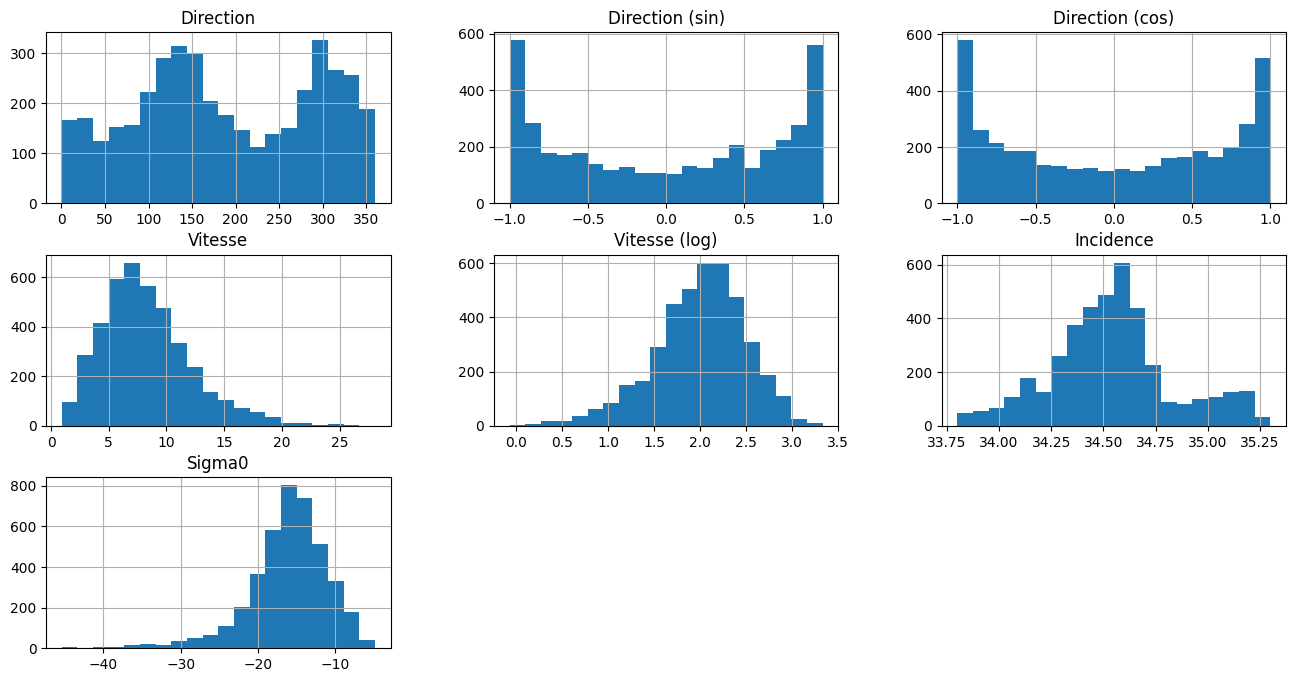

In [22]:
# Distribution des variables brutes
hist = df.hist(bins=20,figsize=(16, 8))

On analyse ici que certains vents dominent notamment vers 130°-150° et vers 300°. Les faibles vitesses sont également plus représentées (décroissance exponentielle). Enfin, les valeurs de l'incidence sont très regroupées dans l'intervalle 34°-35°. On en déduit qu'une normalisation sinus et cosinus est intéressante pour la direction et centrage réduction pour les autres.

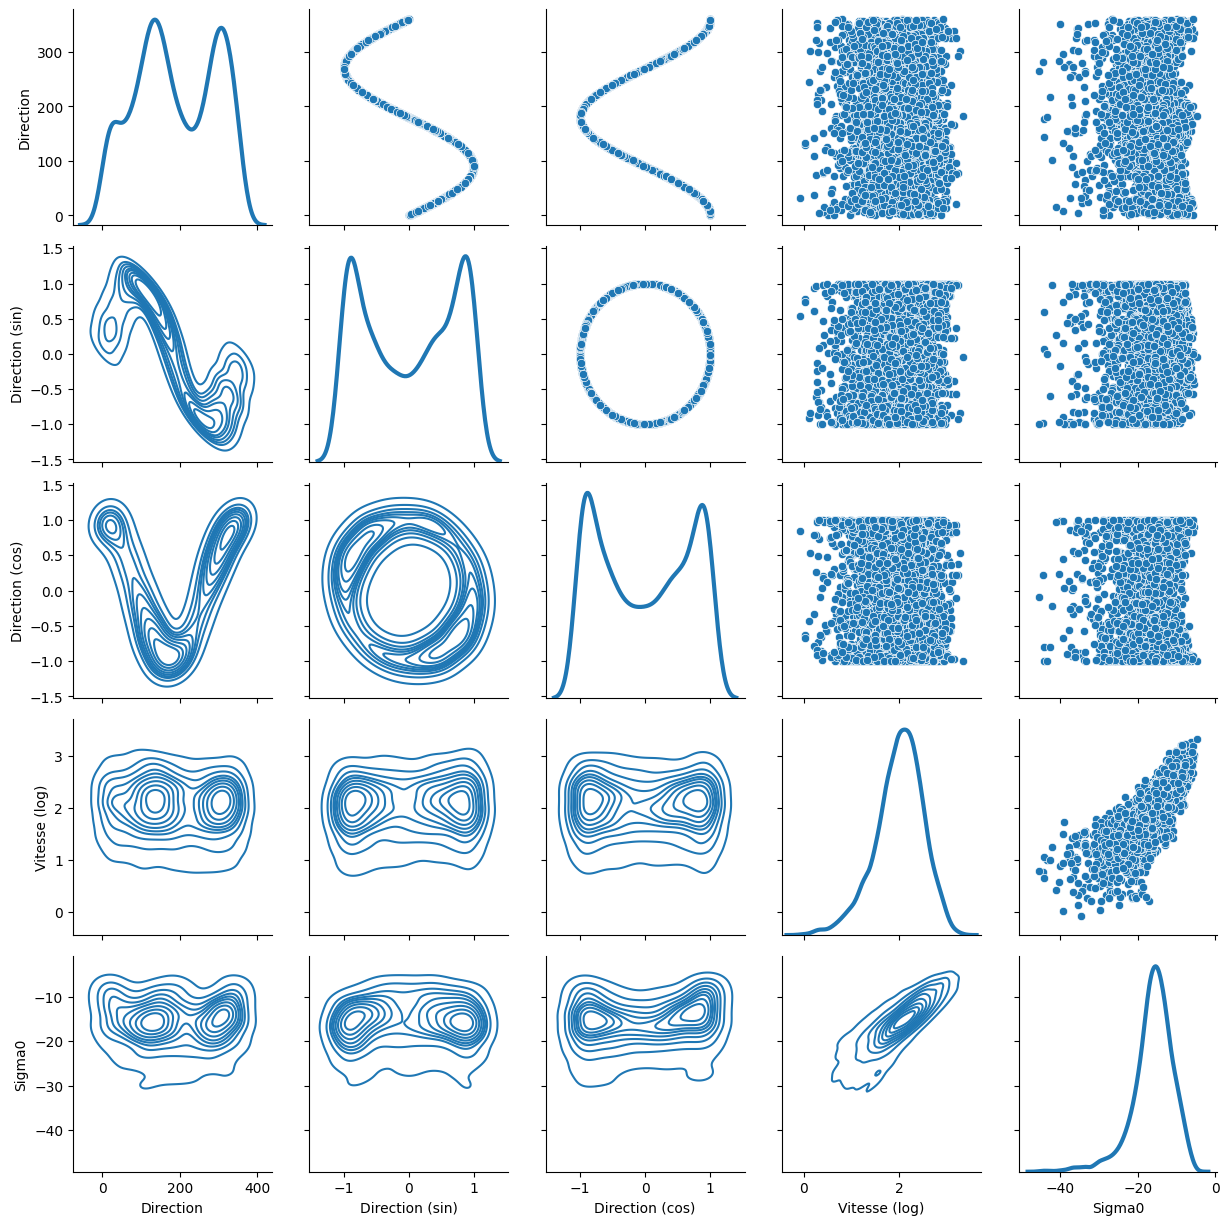

In [14]:
# Analyse des distributions des variables 2 à 2 
g = sns.PairGrid(df[['Direction','Direction (sin)','Direction (cos)','Vitesse (log)','Sigma0']], diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)

Visualisation des dépendances 2 à 2 des variables sous forme de distribution jointe.

***

### Mise en forme et codage des entrées et des sorties du modèle
On normalise par centrage réduction vitesse, incidence et coefficient de rétrodiffusion et simplement par le sinus et cosinus la direction du vent

In [62]:
# moyennes
direction_moyenne = np.mean(direction)
direction_sin_moyenne = np.mean(direction_sin)
direction_cos_moyenne = np.mean(direction_cos)
vitesse_moyenne = np.mean(vitesse)
vitesse_log_moyenne = np.mean(vitesse_log)
incidence_moyenne = np.mean(incidence)
sigma0_moyenne = np.mean(sigma0)

# ecart-types
direction_et = np.std(direction)
direction_sin_et = np.std(direction_sin)
direction_cos_et = np.std(direction_cos)
vitesse_et = np.std(vitesse)
vitesse_log_et = np.std(vitesse_log)
incidence_et = np.std(incidence)
sigma0_et = np.std(sigma0)

# Donnees normalisees et matrice d'entree
DirN        = (direction - direction_moyenne ) /  direction_et  * 2/3
Dir_sinN    = direction_sin
Dir_cosN    = direction_cos
VitN        = (vitesse   - vitesse_moyenne   ) /  vitesse_et  * 2/3
Vit_logN    = (vitesse_log   - vitesse_log_moyenne   ) /  vitesse_log_et  * 2/3
IncN        = (incidence - incidence_moyenne ) / incidence_et * 2/3
SigN        = (sigma0    - sigma0_moyenne    ) / sigma0_et    * 2/3

### Sélection des variables via ACP

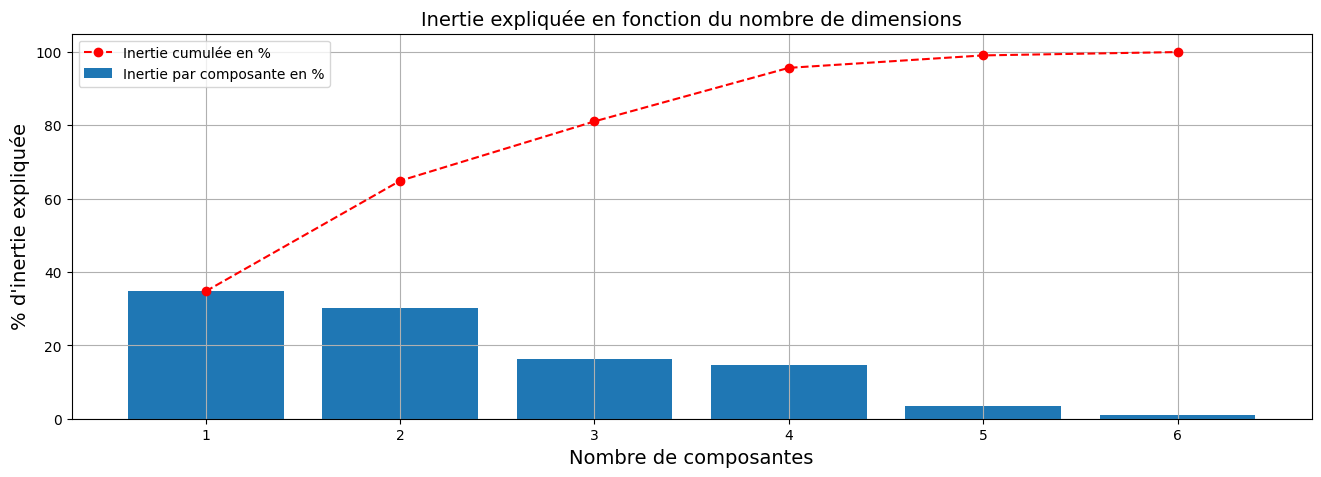

In [57]:
# On utilise évidemment les variables normalisées pour l'APC afin de ne pas biaiser la contribution de chaque variable
XN2 = np.concatenate((DirN, Dir_sinN, Dir_cosN, VitN, Vit_logN, IncN), axis=1)
pca = PCA()
X_pca = pca.fit_transform(XN2)

# Pourcentage de la variance expliquée par chaque composante principale
variance_expliquee = pca.explained_variance_ratio_

plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(variance_expliquee))+1, variance_expliquee*100, label="Inertie par composante en %")
plt.plot(np.arange(len(variance_expliquee))+1, np.cumsum(variance_expliquee*100),'r--o', label="Inertie cumulée en %")
plt.xlabel("Nombre de composantes", fontsize=14)
plt.ylabel("% d'inertie expliquée", fontsize=14)
plt.title("Inertie expliquée en fonction du nombre de dimensions", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

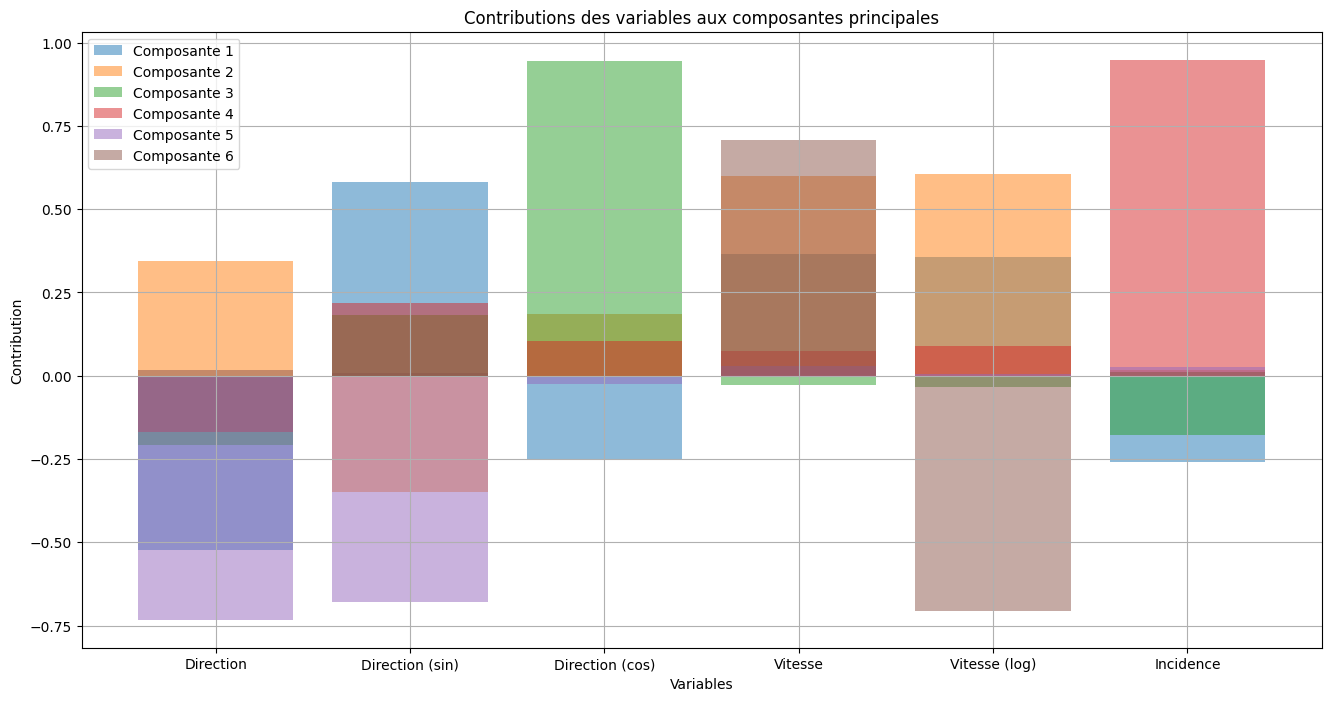

In [58]:
# Contributions des variables aux composantes principales
loadings = pca.components_

plt.figure(figsize=(16, 8))
for i, loading in enumerate(loadings):
    plt.bar(range(len(loading)), loading, alpha=0.5, align='center', label=f'Composante {i+1}')

plt.xlabel('Variables')
plt.ylabel('Contribution')
plt.title('Contributions des variables aux composantes principales')
plt.xticks(range(XN2.shape[1]), [variable for variable in variables[:-1]])
plt.legend()
plt.grid(True)
plt.show()

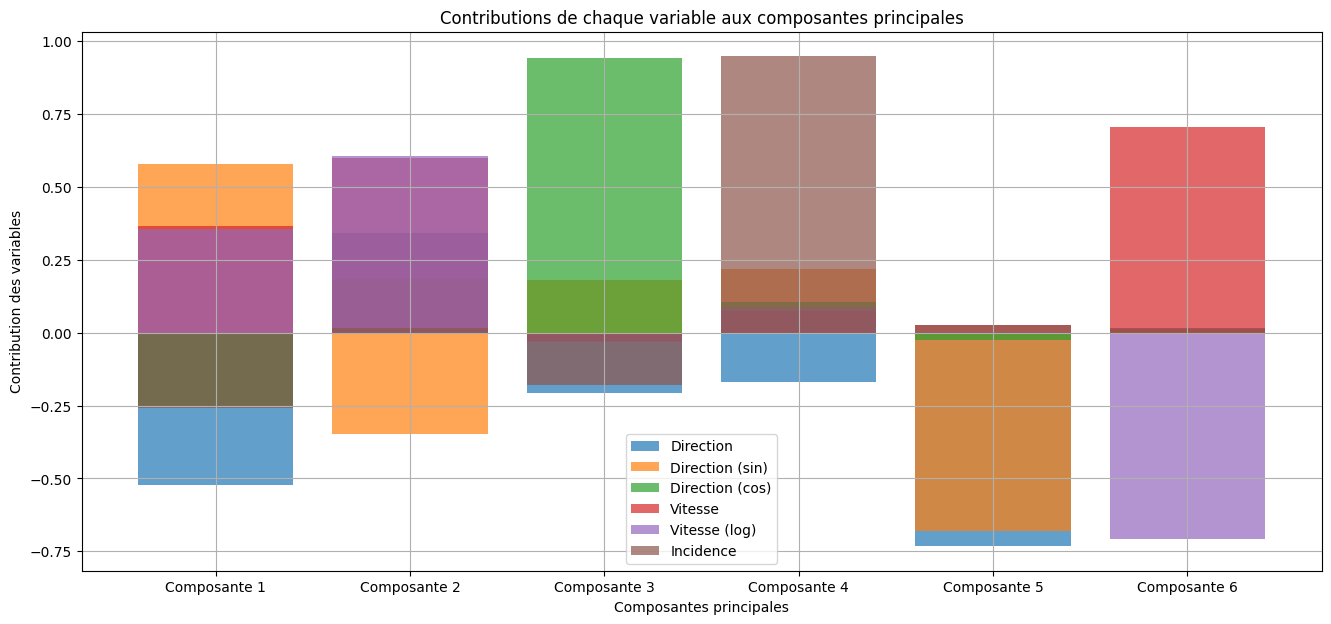

In [60]:
# Représenter les contributions des variables aux composantes principales
plt.figure(figsize=(16, 7))

for i in range(XN2.shape[1]):
    plt.bar([f'Composante {j+1}' for j in range(XN2.shape[1])], loadings[:, i], alpha=0.7, label=variables[i])

plt.xlabel('Composantes principales')
plt.ylabel('Contribution des variables')
plt.title('Contributions de chaque variable aux composantes principales')
plt.legend()
plt.grid(True)
plt.show()

R² moyen par validation croisée: 0.67561152080215
Moyenne des erreurs au carré (MS) : 0.1437080116400436
Racine carrée de la moyenne des erreurs au carré (RMS) : 0.3790883955491695


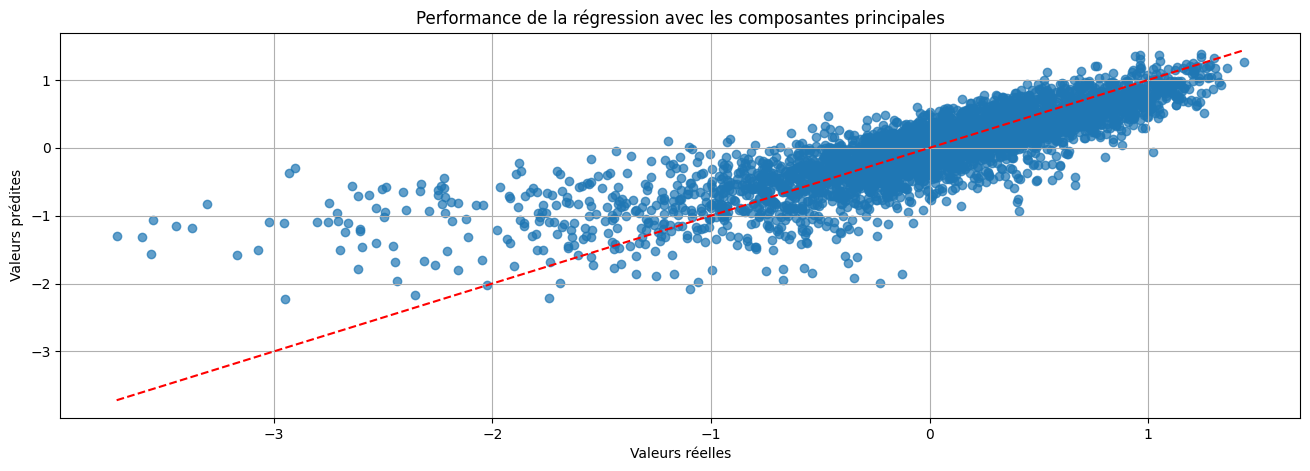

In [171]:
# Régression linéaire avec les composantes principales
model = LinearRegression()

# Validation croisée pour évaluer la performance du modèle
scores = cross_val_score(model, X_pca, SigN, cv=5, scoring='r2')
print(f"R² moyen par validation croisée: {np.mean(scores)}")

# Ajuster le modèle sur toutes les données
model.fit(X_pca, SigN)
y_pred = model.predict(X_pca)

# Calculer les erreurs résiduelles
errors = SigN - y_pred

# Calculer la moyenne des erreurs au carré (MS)
ms = np.mean(errors**2)

# Calculer la racine carrée de la moyenne des erreurs au carré (RMS)
rms = np.sqrt(ms)

print(f"Moyenne des erreurs au carré (MS) : {ms}")
print(f"Racine carrée de la moyenne des erreurs au carré (RMS) : {rms}")

plt.figure(figsize=(16, 5))
plt.scatter(SigN, y_pred, alpha=0.7)
plt.plot([min(SigN), max(SigN)], [min(SigN), max(SigN)], color='red', linestyle='--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title("Performance de la régression avec les composantes principales")
plt.grid(True)
plt.show()

## Conclusion de l'analyse préliminaire

Après normalisation et analyse en composante principale, il en ressort que 3 à 4 variables suffisent à expliquer plus de 80% des variations de la variable cible Sigma0 (règle du coude). Au vu des contributions des variables aux différentes composantes, on peut sélectionner les directions (cosinus et sinus) du vent ainsi que la vitesse du vent car toutes trois ont le meilleur pouvoir explicatif de Sigma0 et que direction et vitesse ne sont que très peu corrélées en elles. Ceci en fait de bons candidats comme variables d'entrée de notre modèle de régression. De plus, l'angle d'incidence n'est que très peu contributif des premières composantes et donc peu explicatif de sigma0.

En revanche, une régression linéaire simple sur les composantes principales n'est pas satisfaisante de par un $R^2$ faible (0.68) mais aussi d'une distribution non normale des résidus du modèle. On va donc devoir utiliser une approche plus puissante qui capte plus la variabilité de la variable d'intérêt Sigma0.

***

In [63]:
# Variable d'entrée du modèle
XN = np.concatenate((Dir_sinN, Dir_cosN, VitN), axis=1)

### Entrées du modèle : Dir_sinN, Dir_cosN et VitN --> XN est la matrice d'entrée du modèle. SigN est la variable d'intérêt normalisée.
On divise les données en 2 avec un ensemble d'entrainement et un ensemble de validation

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(XN, SigN, test_size=1/3)

On a bien des dimensions qui correspondent au nombre de variables d'entrée (3), et de sortie (1) ainsi que le nombre d'individus pour l'entrainement (2732)

In [65]:
X_train.shape, y_train.shape

((2732, 3), (2732, 1))

### Plot de sigma0 en fonction des variables sélectionnées et normalisées

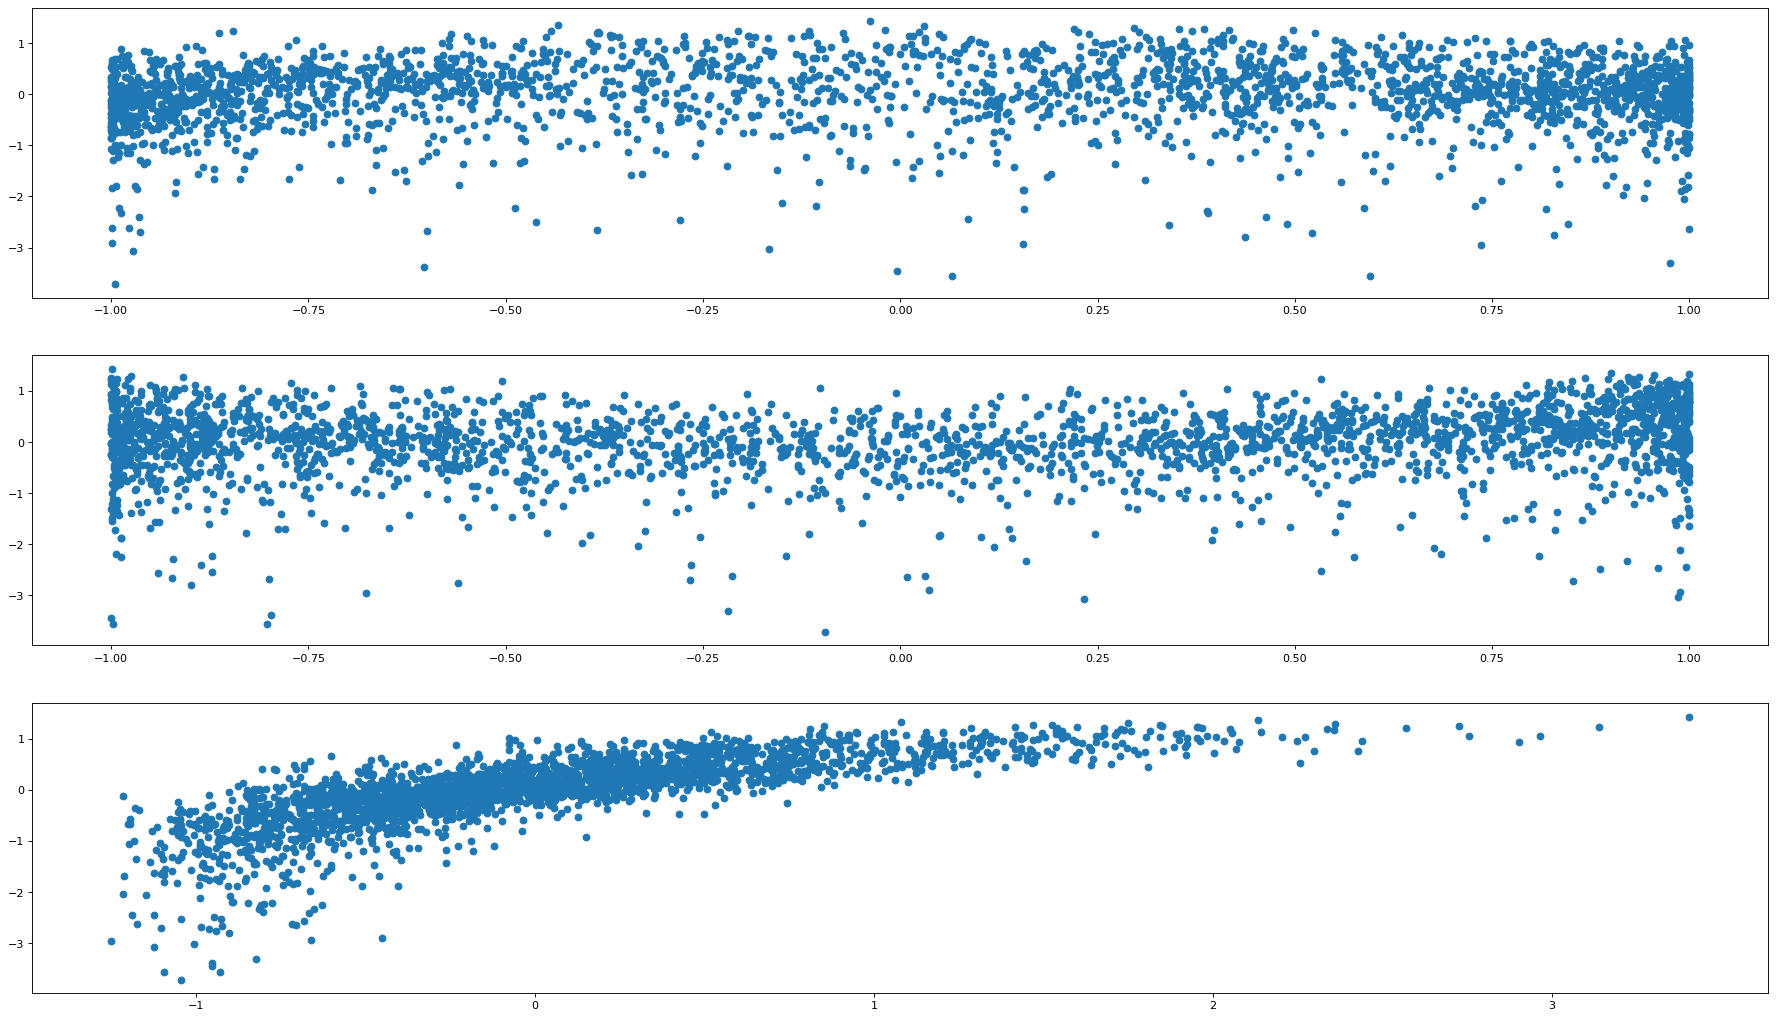

In [66]:
plt.figure(figsize=(28, 16), dpi=80)
for i in range(len(X_train[0])):
    plt.subplot(3,1,i+1)
    plt.scatter(X_train[:,i], y_train)

***

## Modélisation du diffusiomètre NSCAT

On se propose de réaliser une régression par Perceptron Multi-Couches (PMC) pour modéliser la fonction du
diffusiomètre NSCAT. Le rôle du PMC sera donc de donner la valeur de sortie Sigma0 en fonction
de la direction et de la vitesse du vent. On comparera ensuite les performances de ce modèle à la première réalisation de régression linéaire sur les composantes principales de l'ACP.

### Réalisation et apprentissage du PMC

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import TensorDataset, IterableDataset, DataLoader, Dataset, Subset
import torch.optim as optim
import torchvision
from torchvision import transforms
import copy
import types

In [68]:
# fonction tangente hyperbolique pour les neurones cachés et linéaire pour les neurones de sortie
# 5 neurones dans la couche cachée
# Nb iter : 1000
class Mlp(nn.Module):
    def __init__(self,numInput=3,numOutput=1,hidden_layer_sizes=5,activation=nn.Tanh,output_activation=None):
        super(Mlp, self).__init__()

        # mise en forme des dimensions pour creer les couches cachees
        if isinstance(hidden_layer_sizes,int):
            hidden_layer_sizes = (numInput, hidden_layer_sizes, numOutput)
        elif isinstance(hidden_layer_sizes,(list,tuple)):
            hidden_layer_sizes = (numInput,) + tuple(hidden_layer_sizes) + (numOutput,)
        else:
            if not isinstance(hidden_layer_sizes,(list,tuple)):
                raise TypeError("On attend un type ou une liste")
        
        # les couches (lineaires) avec leurs poids
        self.nombreDeCouches = len(hidden_layer_sizes)-1
        for i in range(self.nombreDeCouches):
            setattr(self,'couche_{}'.format(i), nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i+1]))
        
        # les fonctions d'activations pour la suite
        if isinstance(activation,(types.FunctionType,types.BuiltinFunctionType)):
            self.activation=activation
        else :
            raise TypeError("""Unexpected type for activation "{}".""".format(type(activation)))
        
        # activation pour la derniere couche (par defaut rien -> activation == identite)
        if output_activation is None or isinstance(output_activation,(types.FunctionType,types.BuiltinFunctionType)):
            self.output_activation=output_activation
        else :
            raise TypeError("""Unexpected type for output_activation "{}".""".format(type(output_activation)))
        

    def forward(self, x):
        n = self.nombreDeCouches-1
        for i in range(n):
            x = getattr(self,'couche_{}'.format(i))(x)
            x = self.activation(x)
        x = getattr(self,'couche_{}'.format(n))(x)
        if self.output_activation is not None:
                x = self.output_activation(x)
        return x
    

    def __str__(self):
        n = self.nombreDeCouches-1
        reponse = "".join(["(couche {}) : {} [-> activation:{}]\n".format(i,getattr(self,'couche_{}'.format(i)),self.activation.__name__) for i in range(n)])
        if self.output_activation is None:
            reponse += "(couche {}) : {}  [-> activation:{}]".format(n,getattr(self,'couche_{}'.format(n)),"identite")
        else:
            reponse += "(couche {}) : {}  [-> activation:{}]".format(n,getattr(self,'couche_{}'.format(n)),self.output_activation.__name__)
        return reponse             

In [69]:
class Dataset_torch(Dataset):
    def __init__(self, input, target):
        self.input, self.target = input, target
        self.input = torch.tensor(self.input[:,None], device='cpu',dtype=torch.float32)
        self.target = torch.tensor(self.target[:,None], device='cpu',dtype=torch.float32)
        if self.input.shape[0] != self.target.shape[0]:
            raise ValueError("probleme d'individus")

    def __len__(self):
        return self.input.shape[0]

    def __getitem__(self, idx):
        return self.input[idx,:], self.target[idx,:]

### Initialisation et création des listes de résultats

In [93]:
modele_enCours = Mlp(numInput=3, numOutput=1, hidden_layer_sizes=5, activation=torch.tanh)
modele_non_appris = copy.deepcopy(modele_enCours)
couts_apprentissage = []
couts_validation = []
modeles_issusDesApprentissages = []
modeles_issusDesApprentissages.append(copy.deepcopy(modele_enCours))
epoch_number = 0

In [94]:
N_input = X_train.shape[1]
N_output = y_train.shape[1]
mlp = Mlp(numInput=3, numOutput=1, hidden_layer_sizes=10, activation=F.tanh, output_activation=None)
EPOCHS = 100
LR = 0.01
BATCH_SIZE=X_train.shape[0]
optimiseur = torch.optim.Adam(modele_enCours.parameters(), lr=LR)
fonctionDeCout = torch.nn.MSELoss() 
train_dataset = Dataset_torch(X_train, y_train)
val_dataset = Dataset_torch(X_val, y_val)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = Data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [95]:
def un_cycle_d_apprentissage(epoch_index_, dataloader_apprentissage_, modele_, fonctionDeCout_, optimiseur_):
    cout_total = 0.
    nombreDeDonnees = 0
    for i, donnees in enumerate(dataloader_apprentissage_):
        # chaque donnée est un couple (entrée, sortie)
        entrees, desirees = donnees
        
        # remise à zéro du gradient
        optimiseur_.zero_grad()

        # on réalise une prédiction pour les données du lot
        sorties = modele_(entrees)

        # Calcul du coût et du gradient associé
        cout = fonctionDeCout_(sorties, desirees)
        cout.backward()

        # on cumule les couts quadratiques sur les lots pour retourner un cout quadratique moyen
        cout_total += cout.item()*len(donnees)
        nombreDeDonnees += len(donnees)
        
        # ajustement des poids (paramètres du modèle)
        optimiseur_.step()
        
    return cout_total/nombreDeDonnees # cout quadratique moyen

In [96]:
def apprentissage(EPOCHS_, modele_, fonctionDeCout_, optimiseur_, dataloader_apprentissage_, dataloader_validation_, couts_apprentissage_, couts_validation_, epoch_number_=0, verbose=True):
    # meilleur cout de validation sur ce qui precede
    if len(couts_validation_) != 0:
        meilleur_cout_validation = max(couts_validation_)
    else:
        meilleur_cout_validation = -np.inf
    
    # boucle sur les cycles d'apprentissage
    for epoch in range(EPOCHS_):
        # On s'assure que le suivi du gradient est activé quand on itère sur les données
        modele_.train(True)
        cout_moyen_apprentissage = un_cycle_d_apprentissage(epoch_number_, dataloader_apprentissage_, modele_, fonctionDeCout_, optimiseur_)
        couts_apprentissage_.append(cout_moyen_apprentissage)

        # On n'a pas besoin des gradient pour ce qui suit
        modele_.train(False)

        # calcul du cout sur la validation
        cout_total_temp_ = 0.0
        nombre_total_donnees_validation_ = 0
        for i, donnees_v in enumerate(dataloader_validation_):
            entrees_v, desirees_v = donnees_v
            sorties_v = modele_(entrees_v)
            cout_total_temp_ += fonctionDeCout_(sorties_v, desirees_v)*len(donnees_v)
            nombre_total_donnees_validation_ += len(donnees_v)
        cout_moyen_validation = cout_total_temp_.item() / nombre_total_donnees_validation_
        couts_validation_.append(cout_moyen_validation)

        # sauvegarde du réseau
        if epoch == 0 or meilleur_cout_validation > cout_moyen_validation:
            meilleur_cout_validation = cout_moyen_validation
            meilleur_modele_appris = copy.deepcopy(modele_)

        # affichage 
        if (epoch_number_==0 or (epoch_number_+1)%100==0) and verbose==True:
            print('epoch {:5d} -> cout (app.:{:9.6f}, valid:{:9.6f})'.format(epoch_number_+1, cout_moyen_apprentissage, cout_moyen_validation))
        epoch_number_ += 1
    return meilleur_modele_appris, epoch_number_

In [97]:
for i in range(10): # on lance plusieurs apprentissage pour avoir des modeles intermediaires
    meilleur_modele_appris, epoch_number = apprentissage(EPOCHS, modele_enCours, fonctionDeCout, optimiseur, train_loader, val_loader, couts_apprentissage, couts_validation, epoch_number)
    modeles_issusDesApprentissages.append(copy.deepcopy(modele_enCours))

epoch     1 -> cout (app.: 0.461162, valid: 0.438753)
epoch   100 -> cout (app.: 0.148381, valid: 0.142145)
epoch   200 -> cout (app.: 0.137604, valid: 0.128642)
epoch   300 -> cout (app.: 0.135318, valid: 0.125571)
epoch   400 -> cout (app.: 0.133704, valid: 0.122954)
epoch   500 -> cout (app.: 0.133199, valid: 0.122279)
epoch   600 -> cout (app.: 0.133017, valid: 0.122232)
epoch   700 -> cout (app.: 0.132915, valid: 0.122358)
epoch   800 -> cout (app.: 0.132816, valid: 0.122552)
epoch   900 -> cout (app.: 0.132731, valid: 0.122697)
epoch  1000 -> cout (app.: 0.132655, valid: 0.122778)


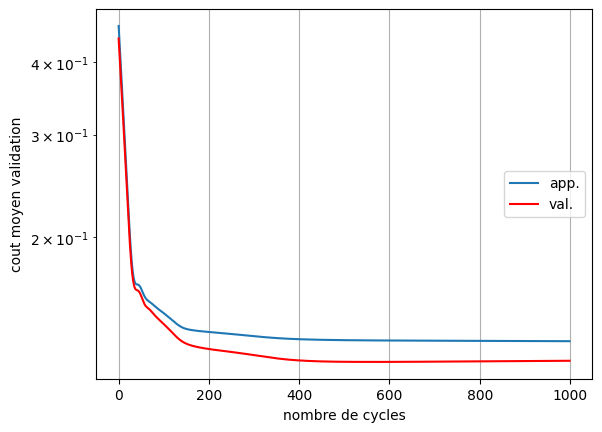

In [98]:
def afficher_erreurs(couts_apprentissage, couts_validation, ax1):
    h1, = ax1.semilogy(couts_apprentissage,'-',label='app.')
    ax2 = ax1
    h2, = ax2.semilogy(couts_validation,'r-',label='val.')
    plt.xlabel('nombre de cycles')
    ax1.set_ylabel('cout moyen apprentissage')
    ax2.set_ylabel('cout moyen validation')
    plt.legend([h1,h2],['app.','val.'],loc='center right')
    ax1.grid(True)
    ax2.grid(True)
fig, ax1 = plt.subplots()
afficher_erreurs(couts_apprentissage, couts_validation, ax1)

### Visualisation et affichage de la fonction estimée

In [99]:
def tracerLesDonneesEnCouleur(x,y,c,classes_edges=None,nombreDeClasses = 100, cb_label=''):
    if classes_edges==None:
        classes_edges = np.linspace(c.min(),c.max(),nombreDeClasses)
    else:
        classes_edges = np.array(classes_edges).astype(float)
    classes_edges[0] , classes_edges[-1] = -np.infty, np.infty
    classes_indices = np.digitize(c,classes_edges)

    cmap = matplotlib.cm.hot
    cmap = matplotlib.cm.jet
    norm = matplotlib.cm.colors.Normalize(vmin=c.min(), vmax=c.max())
    colors = cmap(np.linspace(0,1,nombreDeClasses))
    for k in range(nombreDeClasses):
        selec_classes = np.where(classes_indices==k)
        if len(selec_classes[0]) != 0:
            h = plt.plot(x[selec_classes], y[selec_classes[0]],'.', color=colors[k])

            
    ax = plt.gca()
    pos1 = ax.get_position()
    if False:
        pos2 = [pos1.x0, pos1.y0+pos1.height*.125,  pos1.width , pos1.height*.85] 
        pos3 = [pos1.x0, pos1.y0,  pos1.width , pos1.height*.025] 
        orientation='horizontal'
    else:
        pos2 = [pos1.x0, pos1.y0,  pos1.width*.825 , pos1.height] 
        pos3 = [pos1.x0+pos1.width*.85, pos1.y0,  pos1.width*.025 , pos1.height] 
        orientation='vertical'
            
    ax.set_position(pos2)
    ax_cb = fig.add_axes(pos3)    
    cb = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap, norm=norm, orientation=orientation)
    cb.ax.get_yaxis().labelpad = 15
    cb.ax.set_ylabel(cb_label, rotation=270)
    plt.sca(ax)
    return colors, classes_edges 

## Visualisation théorique

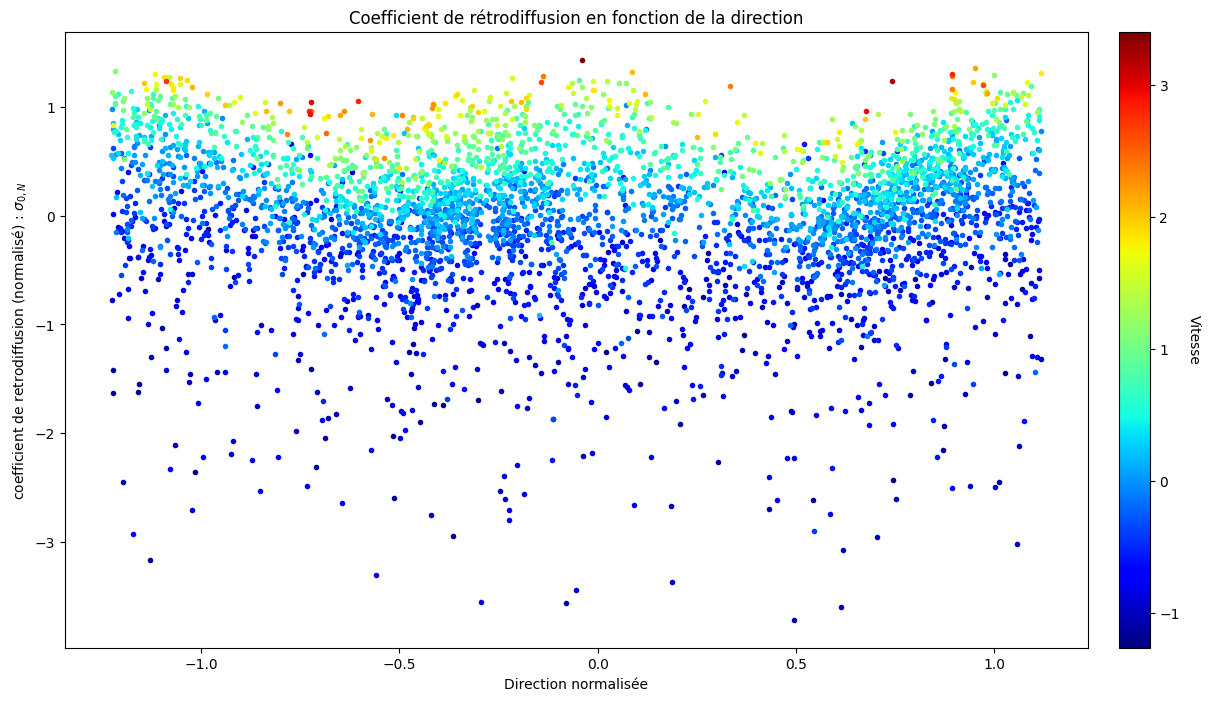

In [102]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
tracerLesDonneesEnCouleur(DirN, SigN, VitN, nombreDeClasses=100, cb_label="Vitesse Normalisée")
plt.title("Coefficient de rétrodiffusion en fonction de la direction")
plt.ylabel("coefficient de retrodiffusion (normalisé) : $\sigma_{0,N}$")
plt.xlabel("Direction normalisée")
plt.show()

***

## Calcul des erreurs

$RMS=\displaystyle\sqrt{\frac{1}{n}\sum_{i=1}^n(x_i^\text{ref}-x_i^\text{ext})^2}$    
$RMS_\text{relative}=\displaystyle\sqrt{\frac{1}{n}\sum_{i=1}^n(\frac{x_i^\text{ref}-x_i^\text{ext}}{x_i^\text{ref}})^2}$    
$Bias=\displaystyle\frac{1}{n}\sum_{i=1}^n(x_i^\text{ref}-x_i^\text{ext})$

***

In [103]:
def calcul_ms_rms_et_biais_mlp_et_donnees(modele_, ensemble_apprentissage, ensemble_validation):
    if not isinstance(modele_,(list,tuple)):
        modele_ = (modele_,)
    ms = np.zeros((len(modele_),3))*np.nan
    rms = np.zeros((len(modele_),3))*np.nan
    biais = np.zeros((len(modele_),3))*np.nan
    liste_des_ensembles = (ensemble_apprentissage,ensemble_validation)
    for i, m_ in enumerate(modele_):
        m_.train(False)
        for j,ensemble in enumerate(liste_des_ensembles):
            y_est_ = m_(ensemble.input).detach().numpy()
            ms[i,j] = ((y_est_[:,0]-ensemble.target[:,0].detach().numpy())**2).mean()
            rms[i,j] = ms[i,j]**.5
            biais[i,j] = (y_est_[:,0]-ensemble.target[:,0].detach().numpy()).mean()
        m_.train(True)
    return ms, rms, biais

In [104]:
modele_ = meilleur_modele_appris
ms, rms, biais = calcul_ms_rms_et_biais_mlp_et_donnees(meilleur_modele_appris,train_dataset,val_dataset)
pd.DataFrame([ms[0, :2], rms[0, :2], biais[0, :2]], columns=['app.', 'val.'], index=['ms', 'rms', 'biais'])

,app.,val.
ms,0.132730,0.122698
rms,0.364321,0.350283
biais,0.000131,-0.010033


Données des métriques d'erreurs pour les deux ensembles de données 
***

### On regroupe les données par intervalles pour une meilleure visualisation en 3 dimensions

In [119]:
# Direction : 0°-60° ; 60°-120° ; 120°-180° ; 180°-240° ; 240°-300° ; 300°-360°
list_indice_dir = [[] for _ in range(6)]
interval_limits = [60, 120, 180, 240, 300]
for i, data in enumerate(direction[:1366]):
    index = next((j for j, limit in enumerate(interval_limits) if data[0] < limit), 5)
    list_indice_dir[index].append(i)

# Vitesse : 0 à 30 par pas de 2m/s
list_indice_vit = [[] for _ in range(15)]
interval_limits = [2 * i for i in range(1, 15)]
for i, data in enumerate(vitesse[:1366]):
    index = next((j for j, limit in enumerate(interval_limits) if data[0] < limit), 14)
    list_indice_vit[index].append(i)

In [ ]:
L=[]
for ensemble in list_indice_dir:
    ms, rms, biais = calcul_ms_rms_et_biais_mlp_et_donnees(meilleur_modele_appris, Dataset_torch(train_dataset[ensemble][0], train_dataset[ensemble][1]), Dataset_torch(val_dataset[ensemble][0], val_dataset[ensemble][1]))
    L.append(rms)

In [ ]:
M=[]
for ensemble in list_indice_vit:
    ms, rms, biais = calcul_ms_rms_et_biais_mlp_et_donnees(meilleur_modele_appris, Dataset_torch(train_dataset[ensemble][0], train_dataset[ensemble][1]), Dataset_torch(val_dataset[ensemble][0], val_dataset[ensemble][1]))
    M.append(rms)

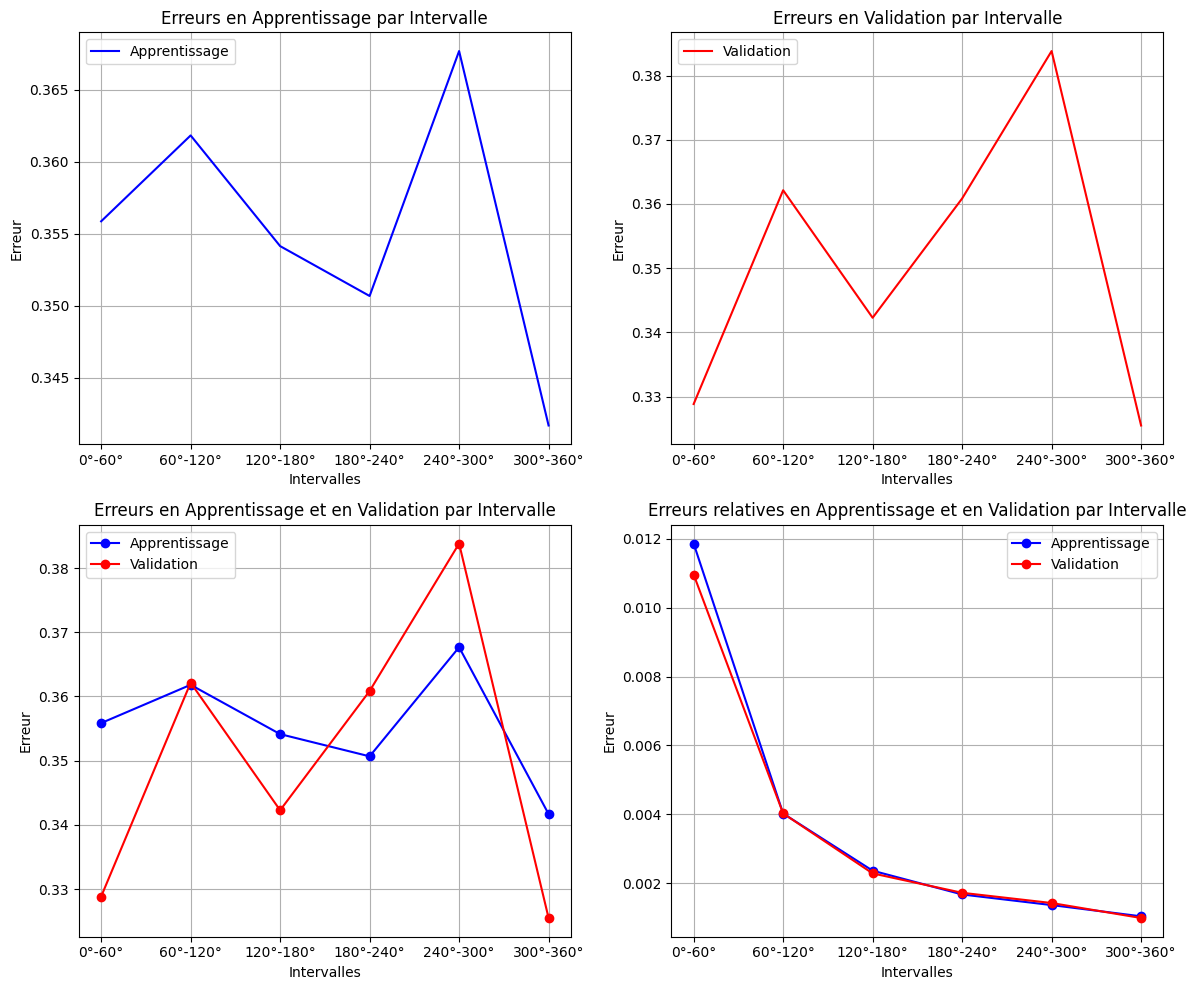

In [163]:
# Direction du vent
apprentissage = [erreur[0, 0] for erreur in L]
validation = [erreur[0, 1] for erreur in L]
indices_categories = [f"{i*60}°-{(i+1)*60}°" for i in range(len(L))]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Tracé du graphique pour les erreurs en apprentissage
axs[0, 0].plot(indices_categories, apprentissage, label='Apprentissage', color='blue')
axs[0, 0].set_title('Erreurs en Apprentissage par Intervalle')
axs[0, 0].set_xlabel('Intervalles')
axs[0, 0].set_ylabel('Erreur')
axs[0, 0].set_xticks(indices_categories)
axs[0, 0].legend()
axs[0, 0].grid(True)

# Tracé du graphique pour les erreurs en validation
axs[0, 1].plot(indices_categories, validation, label='Validation', color='red')
axs[0, 1].set_title('Erreurs en Validation par Intervalle')
axs[0, 1].set_xlabel('Intervalles')
axs[0, 1].set_ylabel('Erreur')
axs[0, 1].set_xticks(indices_categories)
axs[0, 1].legend()
axs[0, 1].grid(True)

# Tracé du graphique pour les erreurs en apprentissage et en validation
axs[1, 0].plot(indices_categories, apprentissage, label='Apprentissage', marker='o', color='blue')
axs[1, 0].plot(indices_categories, validation, label='Validation', marker='o', color='red')
axs[1, 0].set_title('Erreurs en Apprentissage et en Validation par Intervalle')
axs[1, 0].set_xlabel('Intervalles')
axs[1, 0].set_ylabel('Erreur')
axs[1, 0].set_xticks(indices_categories)
axs[1, 0].legend()
axs[1, 0].grid(True)

# Tracé du graphique pour les erreurs relatives en apprentissage et en validation
axs[1, 1].plot(indices_categories, [apprentissage[i] / (30 + i*60) for i in range(len(apprentissage))], label='Apprentissage', marker='o', color='blue')
axs[1, 1].plot(indices_categories, [validation[i] / (30 + i*60) for i in range(len(validation))], label='Validation', marker='o', color='red')
axs[1, 1].set_title('Erreurs relatives en Apprentissage et en Validation par Intervalle')
axs[1, 1].set_xlabel('Intervalles')
axs[1, 1].set_ylabel('Erreur')
axs[1, 1].set_xticks(indices_categories)
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

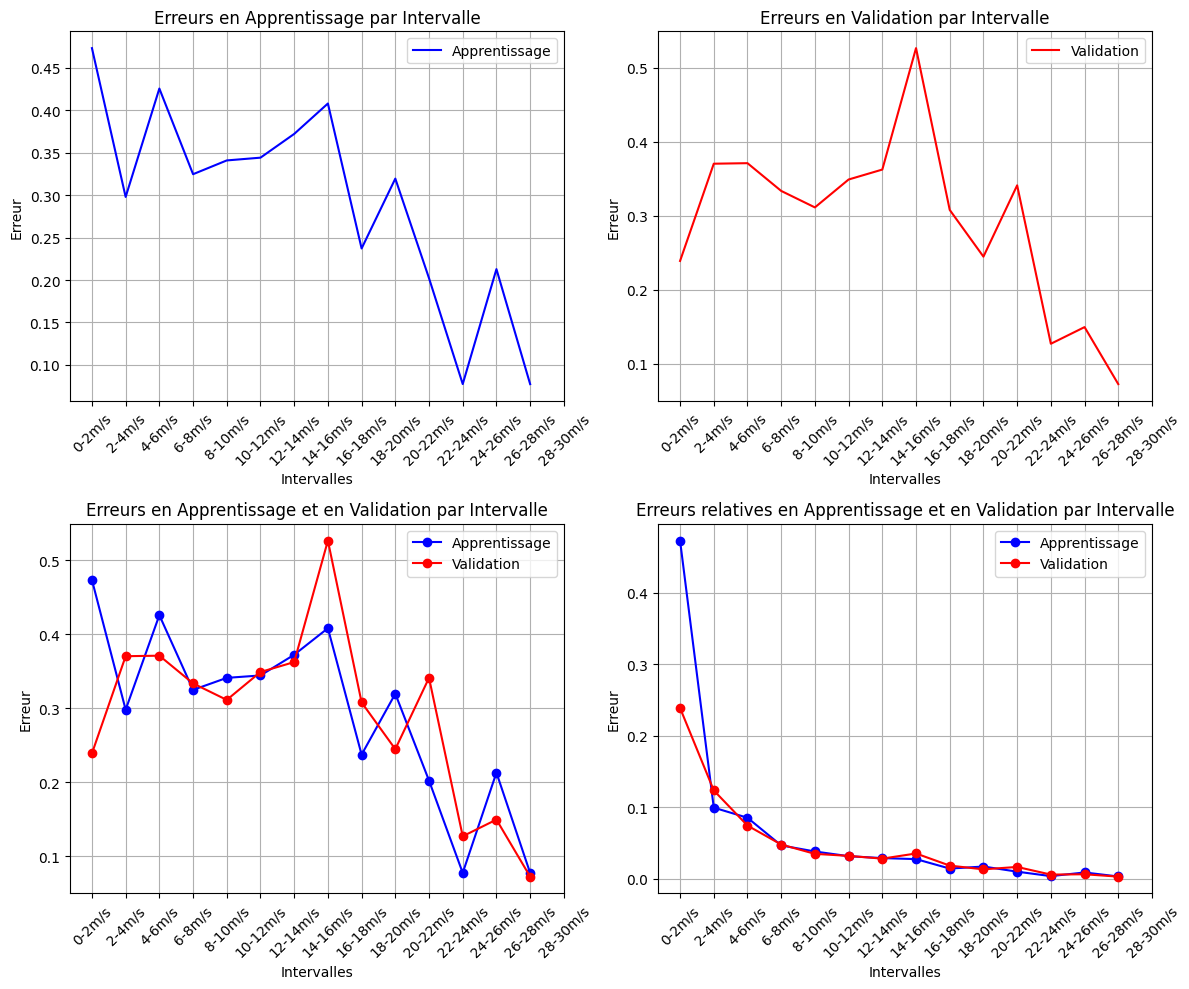

In [164]:
# Vitesse du vent
apprentissage = [erreur[0, 0] for erreur in M]
validation = [erreur[0, 1] for erreur in M]
indices_categories = [f"{i*2}-{(i+1)*2}m/s" for i in range(len(M))]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Tracé du graphique pour les erreurs en apprentissage
axs[0, 0].plot(indices_categories, apprentissage, label='Apprentissage', color='blue')
axs[0, 0].set_title('Erreurs en Apprentissage par Intervalle')
axs[0, 0].set_xlabel('Intervalles')
axs[0, 0].set_ylabel('Erreur')
axs[0, 0].set_xticks(indices_categories)
axs[0, 0].legend()
axs[0, 0].grid(True)
axs[0, 0].tick_params(axis='x', rotation=45)

# Tracé du graphique pour les erreurs en validation
axs[0, 1].plot(indices_categories, validation, label='Validation', color='red')
axs[0, 1].set_title('Erreurs en Validation par Intervalle')
axs[0, 1].set_xlabel('Intervalles')
axs[0, 1].set_ylabel('Erreur')
axs[0, 1].set_xticks(indices_categories)
axs[0, 1].legend()
axs[0, 1].grid(True)
axs[0, 1].tick_params(axis='x', rotation=45)

# Tracé du graphique pour les erreurs en apprentissage et en validation
axs[1, 0].plot(indices_categories, apprentissage, label='Apprentissage', marker='o', color='blue')
axs[1, 0].plot(indices_categories, validation, label='Validation', marker='o', color='red')
axs[1, 0].set_title('Erreurs en Apprentissage et en Validation par Intervalle')
axs[1, 0].set_xlabel('Intervalles')
axs[1, 0].set_ylabel('Erreur')
axs[1, 0].set_xticks(indices_categories)
axs[1, 0].legend()
axs[1, 0].grid(True)
axs[1, 0].tick_params(axis='x', rotation=45)

# Tracé du graphique pour les erreurs relatives en apprentissage et en validation
axs[1, 1].plot(indices_categories, [apprentissage[i] / (1 + i*2) for i in range(len(apprentissage))], label='Apprentissage', marker='o', color='blue')
axs[1, 1].plot(indices_categories, [validation[i] / (1 + i*2) for i in range(len(validation))], label='Validation', marker='o', color='red')
axs[1, 1].set_title('Erreurs relatives en Apprentissage et en Validation par Intervalle')
axs[1, 1].set_xlabel('Intervalles')
axs[1, 1].set_ylabel('Erreur')
axs[1, 1].set_xticks(indices_categories)
axs[1, 1].legend()
axs[1, 1].grid(True)
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Etudes complémentaires des moyennes et nombre de valeurs par intervalle

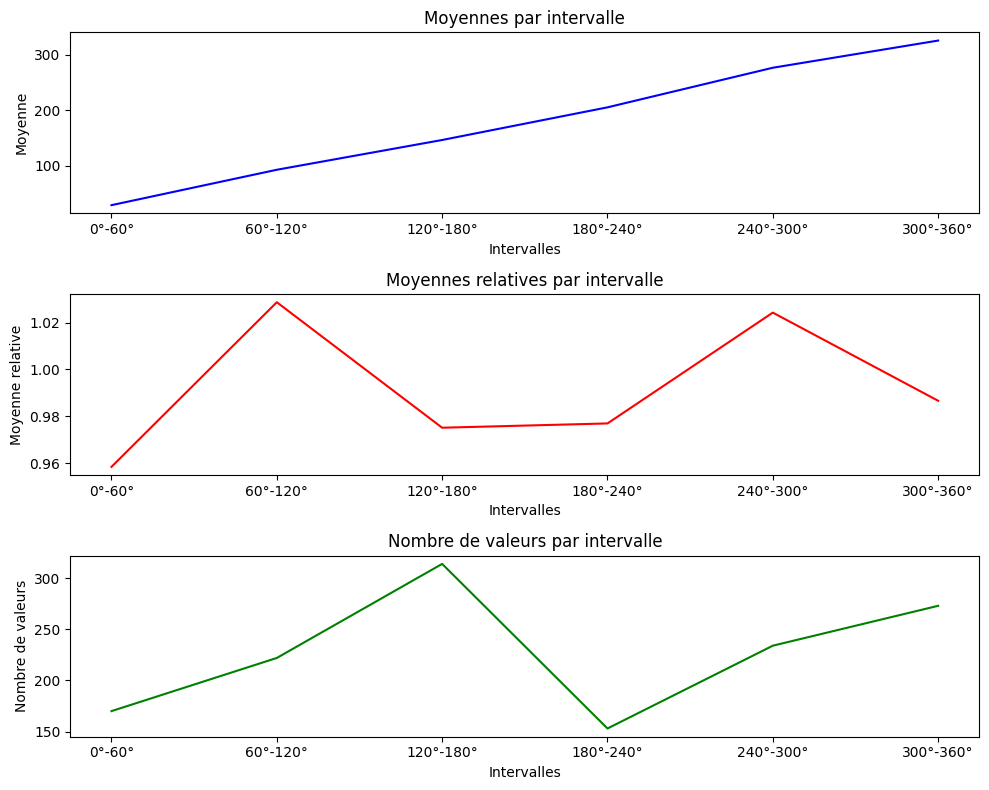

In [153]:
moyennes = []
nombres_valeurs = []
for sous_liste in list_indice_dir:
    lst = [direction[i] for i in sous_liste]
    moyenne = sum(lst) / len(lst)
    nombre_valeurs = len(lst)
    moyennes.append(moyenne)
    nombres_valeurs.append(nombre_valeurs)

plt.figure(figsize=(10, 8))
indices_categories_dir = [f"{i*60}°-{(i+1)*60}°" for i in range(len(L))]

# Tracé des moyennes
plt.subplot(3, 1, 1)
plt.plot(indices_categories_dir, moyennes, color='blue')
plt.title('Moyennes par intervalle')
plt.xlabel('Intervalles')
plt.ylabel('Moyenne')

# Tracé des moyennes relatives
plt.subplot(3, 1, 2)
plt.plot(indices_categories_dir, [moyennes[i] / (30 + i*60) for i in range(len(moyennes))], color='red')
plt.title('Moyennes relatives par intervalle')
plt.xlabel('Intervalles')
plt.ylabel('Moyenne relative')

# Tracé du nombre de valeurs
plt.subplot(3, 1, 3)
plt.plot(indices_categories_dir, nombres_valeurs, color='green')
plt.title('Nombre de valeurs par intervalle')
plt.xlabel('Intervalles')
plt.ylabel('Nombre de valeurs')

plt.tight_layout()
plt.show()

C:\Users\matth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


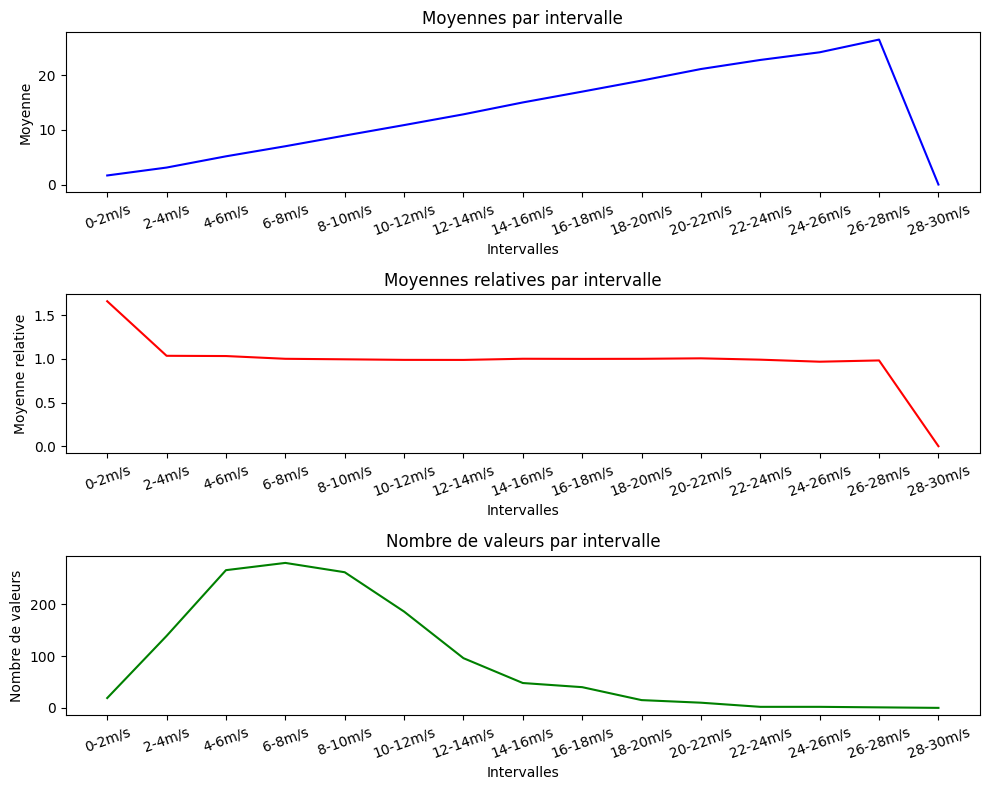

In [154]:
moyennes = []
nombres_valeurs = []
for sous_liste in list_indice_vit:
    lst = [vitesse[i] for i in sous_liste]
    moyenne = sum(lst) / len(lst) if lst != [] else 0
    nombre_valeurs = len(lst)
    moyennes.append(moyenne)
    nombres_valeurs.append(nombre_valeurs)

plt.figure(figsize=(10, 8))
indices_categories_vent = [f"{i*2}-{(i+1)*2}m/s" for i in range(len(M))]

# Tracé des moyennes
plt.subplot(3, 1, 1)
plt.plot(indices_categories_vent, moyennes, color='blue')
plt.title('Moyennes par intervalle')
plt.xlabel('Intervalles')
plt.ylabel('Moyenne')
plt.xticks(rotation=20)

# Tracé des moyennes relatives
plt.subplot(3, 1, 2)
plt.plot(indices_categories_vent, [moyennes[i] / (1 + i*2) for i in range(len(moyennes))], color='red')
plt.title('Moyennes relatives par intervalle')
plt.xlabel('Intervalles')
plt.ylabel('Moyenne relative')
plt.xticks(rotation=20)

# Tracé du nombre de valeurs
plt.subplot(3, 1, 3)
plt.plot(indices_categories_vent, nombres_valeurs, color='green')
plt.title('Nombre de valeurs par intervalle')
plt.xlabel('Intervalles')
plt.ylabel('Nombre de valeurs')
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()

On observe grâce aux graphes précédents que les erreurs moyennes par intervalles de direction ou vitesse de vent ne sont pas constants. Ceci peut être du à une mauvaise modélisation ou à un surapprentissage sur certaines plages de données or, en réalisant une étude complémentaire relatives aux données, on comprend qu'elles ne sont ni indépendantes ni identiquement distribuées dans ces intervalles. En analysant les erreurs relatives à la moyenne des données de chaque intervalle, on trouve des résultats nettement plus satisfaisants : les erreurs sont constantes sur les plages de valeurs des variables (ou presque). Ceci renforce la confiance que l'on porte à notre modèle quant à la bonne réalisation de l'apprentissage.
***

In [135]:
# On dénormalise les prédictions du modèles
output_train = meilleur_modele_appris(train_dataset.input)
output_train_denormalized = output_train * 3/2 * sigma0_et + sigma0_moyenne
output_train_denormalized = [torch.squeeze(tenseur).detach().numpy() for tenseur in output_train_denormalized]
erreurs_pred = output_train_denormalized - sigma0.squeeze()[:2732]

### Etude de la distribution des erreurs de prédiction de notre modèle

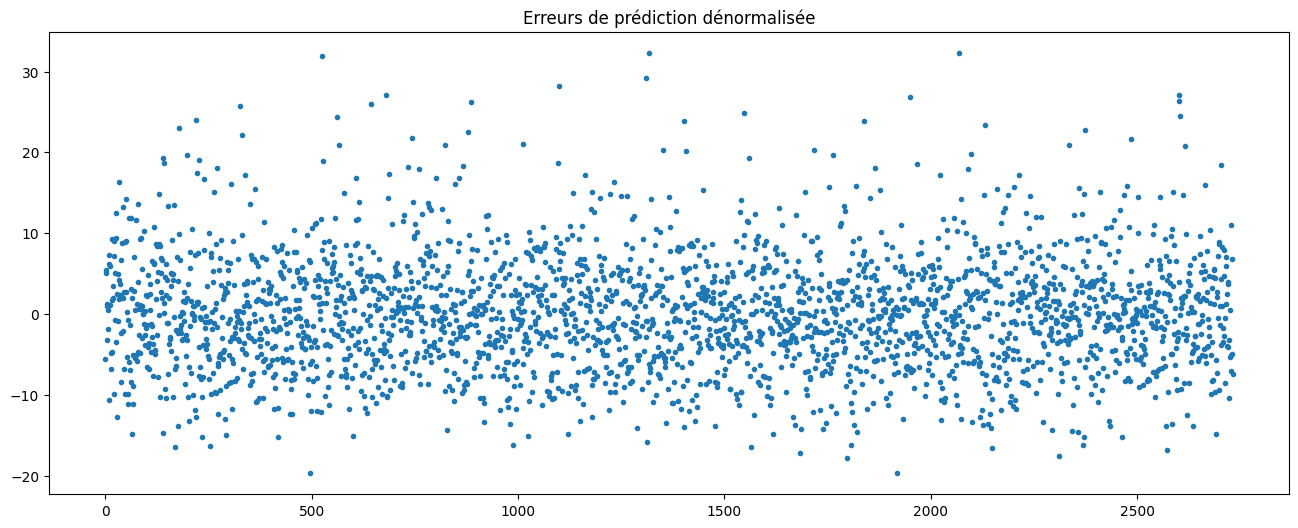

In [168]:
plt.figure(figsize=(16, 6))
plt.scatter([i for i in range(2732)], erreurs_pred, marker='.')
plt.title('Erreurs de prédiction dénormalisée')
plt.show()

Erreur de prédiction avec une distribution normale, centrée et sans pattern apparent. Les résidus ne portent plus d'information à première vue.

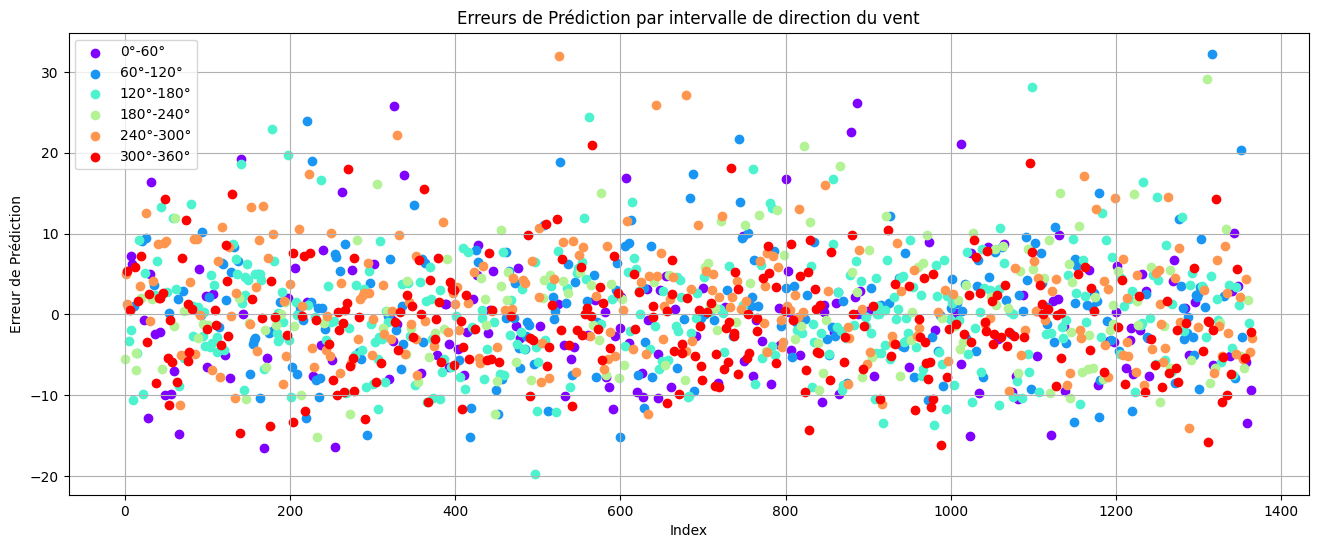

In [170]:
colors_cat1 = plt.cm.rainbow(np.linspace(0, 1, len(L)))
colors_cat2 = plt.cm.rainbow(np.linspace(0, 1, len(M)))

plt.figure(figsize=(16, 6))
for i, indices in enumerate(list_indice_dir):
    plt.scatter(indices, erreurs_pred[indices], color=colors_cat1[i], label=indices_categories_dir[i])

plt.xlabel('Index')
plt.ylabel('Erreur de Prédiction')
plt.title('Erreurs de Prédiction par intervalle de direction du vent')
plt.legend()
plt.grid(True)
plt.show()

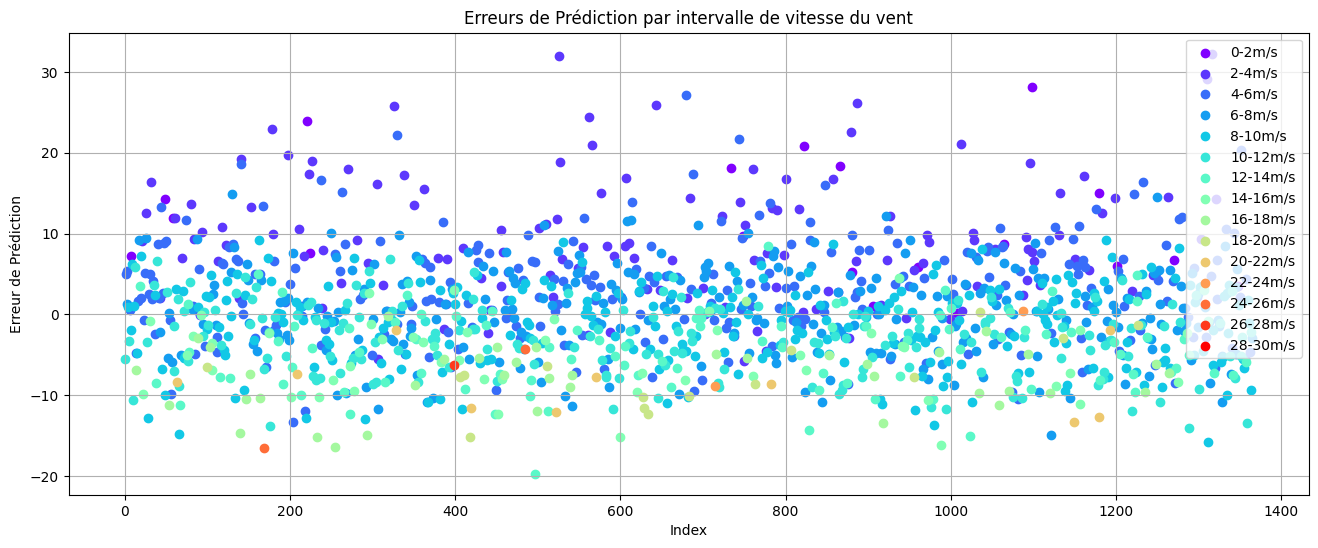

In [156]:
plt.figure(figsize=(16, 6))
for j, indices in enumerate(list_indice_vit):
    plt.scatter(indices, erreurs_pred[indices], color=colors_cat2[j], label=indices_categories_vent[j])

plt.xlabel('Index')
plt.ylabel('Erreur de Prédiction')
plt.title('Erreurs de Prédiction par intervalle de vitesse du vent')
plt.legend()
plt.grid(True)
plt.show()

Les directions du vent sont réparties de manière uniforme (1er graphe) autour de 0 et de chaque côté. Pour la vitesse du vent, on retrouve la même conclusion concernant les valeurs de vitesse au dessus de 4m/s. Quant aux petites valeurs de vitesse du vent, elles admettent de plus grandes erreurs de prédiction.
***

## Visualisation des prédictions selon la direction (abscisse) et la vitesse (couleur) du vent

In [137]:
output_train = [torch.squeeze(tenseur).detach().numpy() for tenseur in output_train]
output_train = np.array([[float(x)] for x in output_train])

output_train_denormalized = np.array([[float(x)] for x in output_train_denormalized])

dir1 = np.degrees([np.arctan2(X_train[i,0], X_train[i,1]) for i in range(len(X_train[:,0]))]) + 180
vit1 = np.array([elem * 3/2 * vitesse_et + vitesse_moyenne for elem in X_train[:,2]])

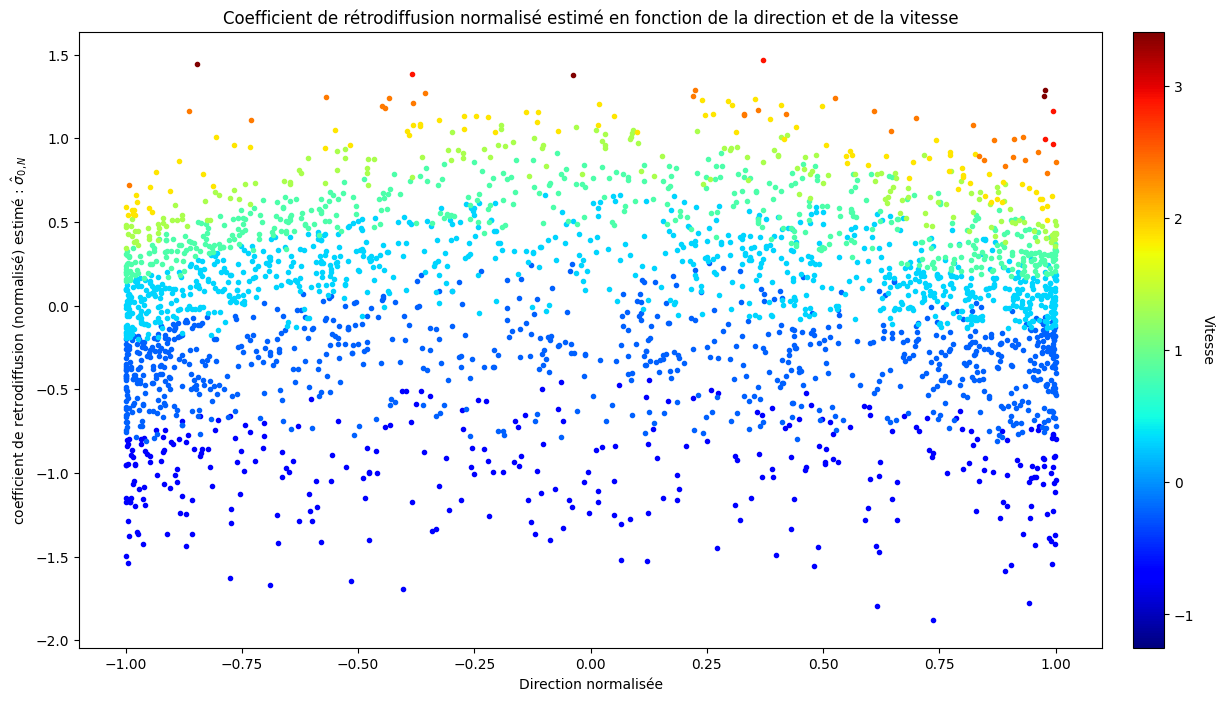

In [140]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
tracerLesDonneesEnCouleur(X_train[:,0], output_train, X_train[:,2], classes_edges=None, nombreDeClasses = 10, cb_label="Vitesse Normalisée")
plt.title("Coefficient de rétrodiffusion normalisé estimé en fonction de la direction et de la vitesse")
plt.ylabel("coefficient de retrodiffusion (normalisé) estimé : $\hat{\sigma}_{0,N}$")
plt.xlabel("Direction normalisée")
plt.show()

### Dénormalisation et Interprétation

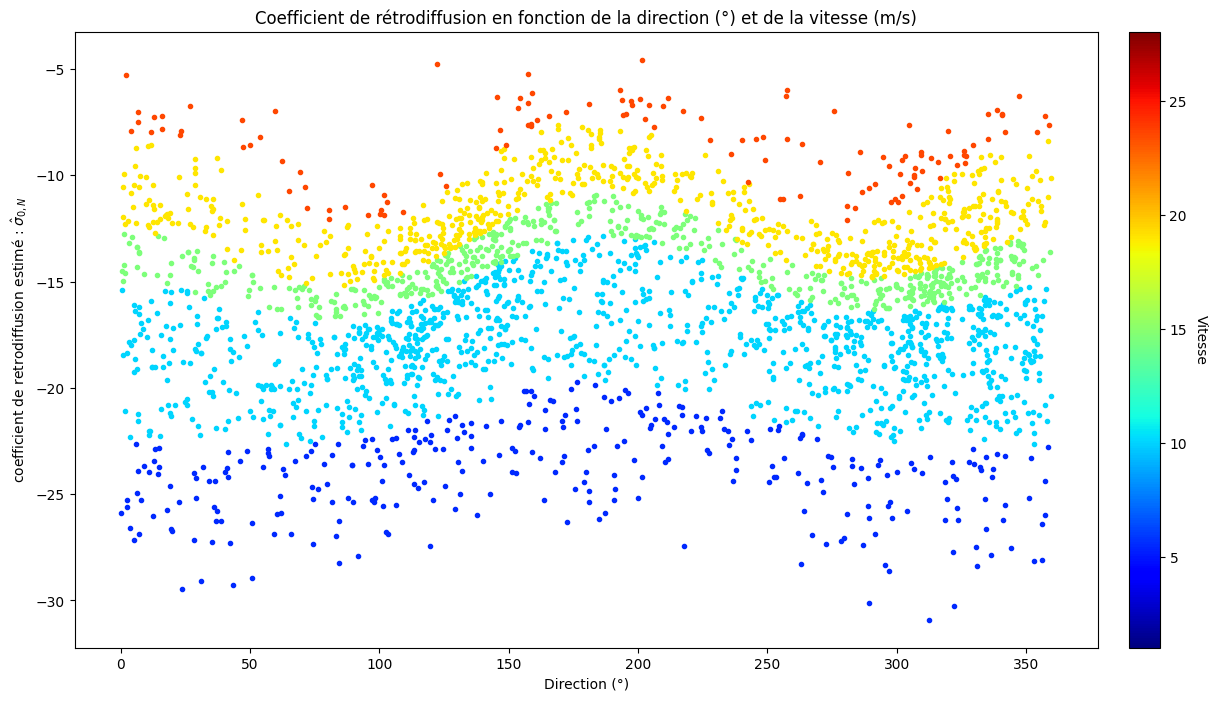

In [142]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
tracerLesDonneesEnCouleur(dir1, output_train_denormalized, vit1, classes_edges=[2, 4, 8, 10, 16, 20], nombreDeClasses=7, cb_label="Vitesse")
plt.title("Coefficient de rétrodiffusion en fonction de la direction (°) et de la vitesse (m/s)")
plt.ylabel("coefficient de retrodiffusion estimé : $\hat{\sigma}_{0,N}$")
plt.xlabel("Direction (°)")
plt.show()

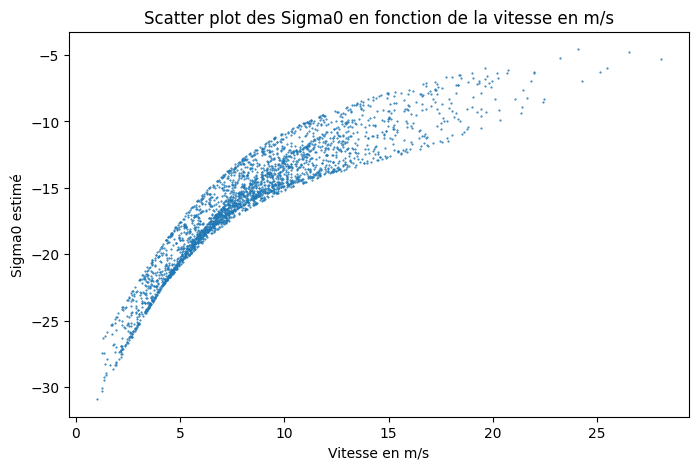

In [162]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.scatter(vit1, output_train_denormalized, s=1, marker='.')
plt.xlabel('Vitesse en m/s')
plt.ylabel('Sigma0 estimé')
plt.title('Scatter plot des Sigma0 en fonction de la vitesse en m/s')
plt.show()

Ces derniers graphes nous permettent de modéliser en 3 dimensions les prédictions de notre modèle en fonction des variables d'entrées. Le cosinus et sinus de la direction ont été regroupé afin de générer une seule valeur de la direction en °. Direction, vitesse et prédiction de Sigma0 ont ensuite été dénormalisés afin de retrouver les phénomènes connus et évoqués en introduction de manière théorique. Enfin le 3ème graphique met en valeur la variation des prédictions en fonction uniquement de la vitesse, une sorte de schéma de coupe des précédents graphes. On y trouve une dépendance moins forte pour les grandes valeurs de vitesse qui se retrouve également dans le dégradé de couleur précédent qui devient de plus en plus compacte avec la vitesse du vent.
***

# Conclusion générale 

On a réussi a réaliser un modèle multi-couche qui présente de meilleure performance que la régression linéaire : une RMS de 0.35 contre 0.38 pour la régression linéaire. Ce qui correspond après dénormalisation à un écart de précision d'environ 0.2 dB sur la variable cible Sigma0.

Le PMC présente également une convergence asymptotique de ses fonctions de coûts en apprentissage et validation après 400-500 itérations. On en déduit que le risque de surapprentissage est éliminé pour ce nombre d'itération de l'algorithme d'apprentissage.

Concernant les analyses par intervalles de direction du vent et de vitesse, il en sort plusieurs phénomènes. Premièrement, les erreurs de prédictions diminuent légèrement avec la vitesse du vent ce qui peut être interprété comme un plus grande précision lorsque le vent est constant et bien établi souvent à des valeurs supérieurs à 10m/s contrairement à un vent instable et changeant plutôt faible (moins de 4m/s). On retrouve cela dans les graphes de distributions des erreurs labelisés avec une couleur selon l'intervalle de vitesse du point. Côté direction du vent on n'observe pas de spécificité quant aux distributions des erreurs de prédictions, en tout cas non significative comparé à la précédente.

Enfin, les graphes du coefficient de rétrodiffusion estimé en fonction de la direction et de la vitesse du vent présentent les mêmes caractéristiques que le graphe théorique en introduction de ce notebook. On observe 2 "vagues" qui perdent en amplitude avec la vitesse du vent et qui sont maximale quand l'angle est dans le sens de la mesure du diffusiomètre à 0° ou 360° mais également en sens inverse (180°) puisque l'impact du vent sur l'eau sera assez similaire. En effet, c'est lorsque le vent est le plus fort et le plus aligné avec l'angle de mesure du satellite que les vaguelettes créée vont le plus interagir avec les ondes émissent par le diffusiomètre et donc retourer un signal plus fort (coefficient de rétrodiffusion Sigma0 plus élevé).

***

***Réalisation : Baptiste ZLOCH et Matthieu MONNOT***